
![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/FOUNDATIONONE_REPORT_PARSING.ipynb)

# **Example of extracting table data from Microsoft PPT documents**

## 🔎**Colab Setup** 

In [ ]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.0.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
! pip install spark-ocr==$OCR_VERSION\+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)



## **🔎Import OCR transformers**

In [2]:
import sparkocr
import sys
from pyspark.sql import SparkSession
from sparkocr import start
import base64
from sparkocr.transformers import *
from pyspark.ml import PipelineModel, Pipeline
from pyspark.sql import functions as F
from pyspark.sql.functions import  col
from sparkocr.enums import *
from termcolor import colored
from sparkocr.utils import display_image, display_images, display_pdf, display_tables

In [3]:
# Start spark
spark = sparkocr.start(secret=SPARK_OCR_SECRET, 
                       nlp_version=PUBLIC_VERSION
                       )

spark

Spark version: 3.0.2
Spark NLP version: 3.4.4
Spark OCR version: 3.12.0



In [4]:
spark.conf.set("spark.sql.legacy.allowUntypedScalaUDF", True)
print(spark.conf.get("spark.sql.legacy.allowUntypedScalaUDF"))

true


## **🔎Define OCR transformers and pipeline**

In [5]:
def pipeline():
    
    # Transforrm PDF document to images per page
    pdf_to_text = PdfToText()
    pdf_to_text.setOutputCol("text")
    pdf_to_text.setSplitPage(False)
    pdf_to_text.setSort(True)
    pdf_to_text.setTextStripper(TextStripperType.PDF_LAYOUT_TEXT_STRIPPER)

    fone_parser = FoundationOneReportParser()
    fone_parser.setInputCol("text")
    fone_parser.setOutputCol("foundation")

    
    pipeline = PipelineModel(stages=[
        pdf_to_text,
        fone_parser
    ])
    
    return pipeline

## **🔎Read PDF document as binary file**

In [13]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/foundationone_report.pdf

In [14]:
pdf_example_df = spark.read.format("binaryFile").load('foundationone_report.pdf').cache()
pdf_example_df.show()

+--------------------+--------------------+-------+--------------------+
|                path|    modificationTime| length|             content|
+--------------------+--------------------+-------+--------------------+
|file:/content/fou...|2022-06-13 14:24:...|1260852|[25 50 44 46 2D 3...|
+--------------------+--------------------+-------+--------------------+




    Image #0:
    Origin: file:/content/foundationone_report.pdf
    Resolution: 300 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


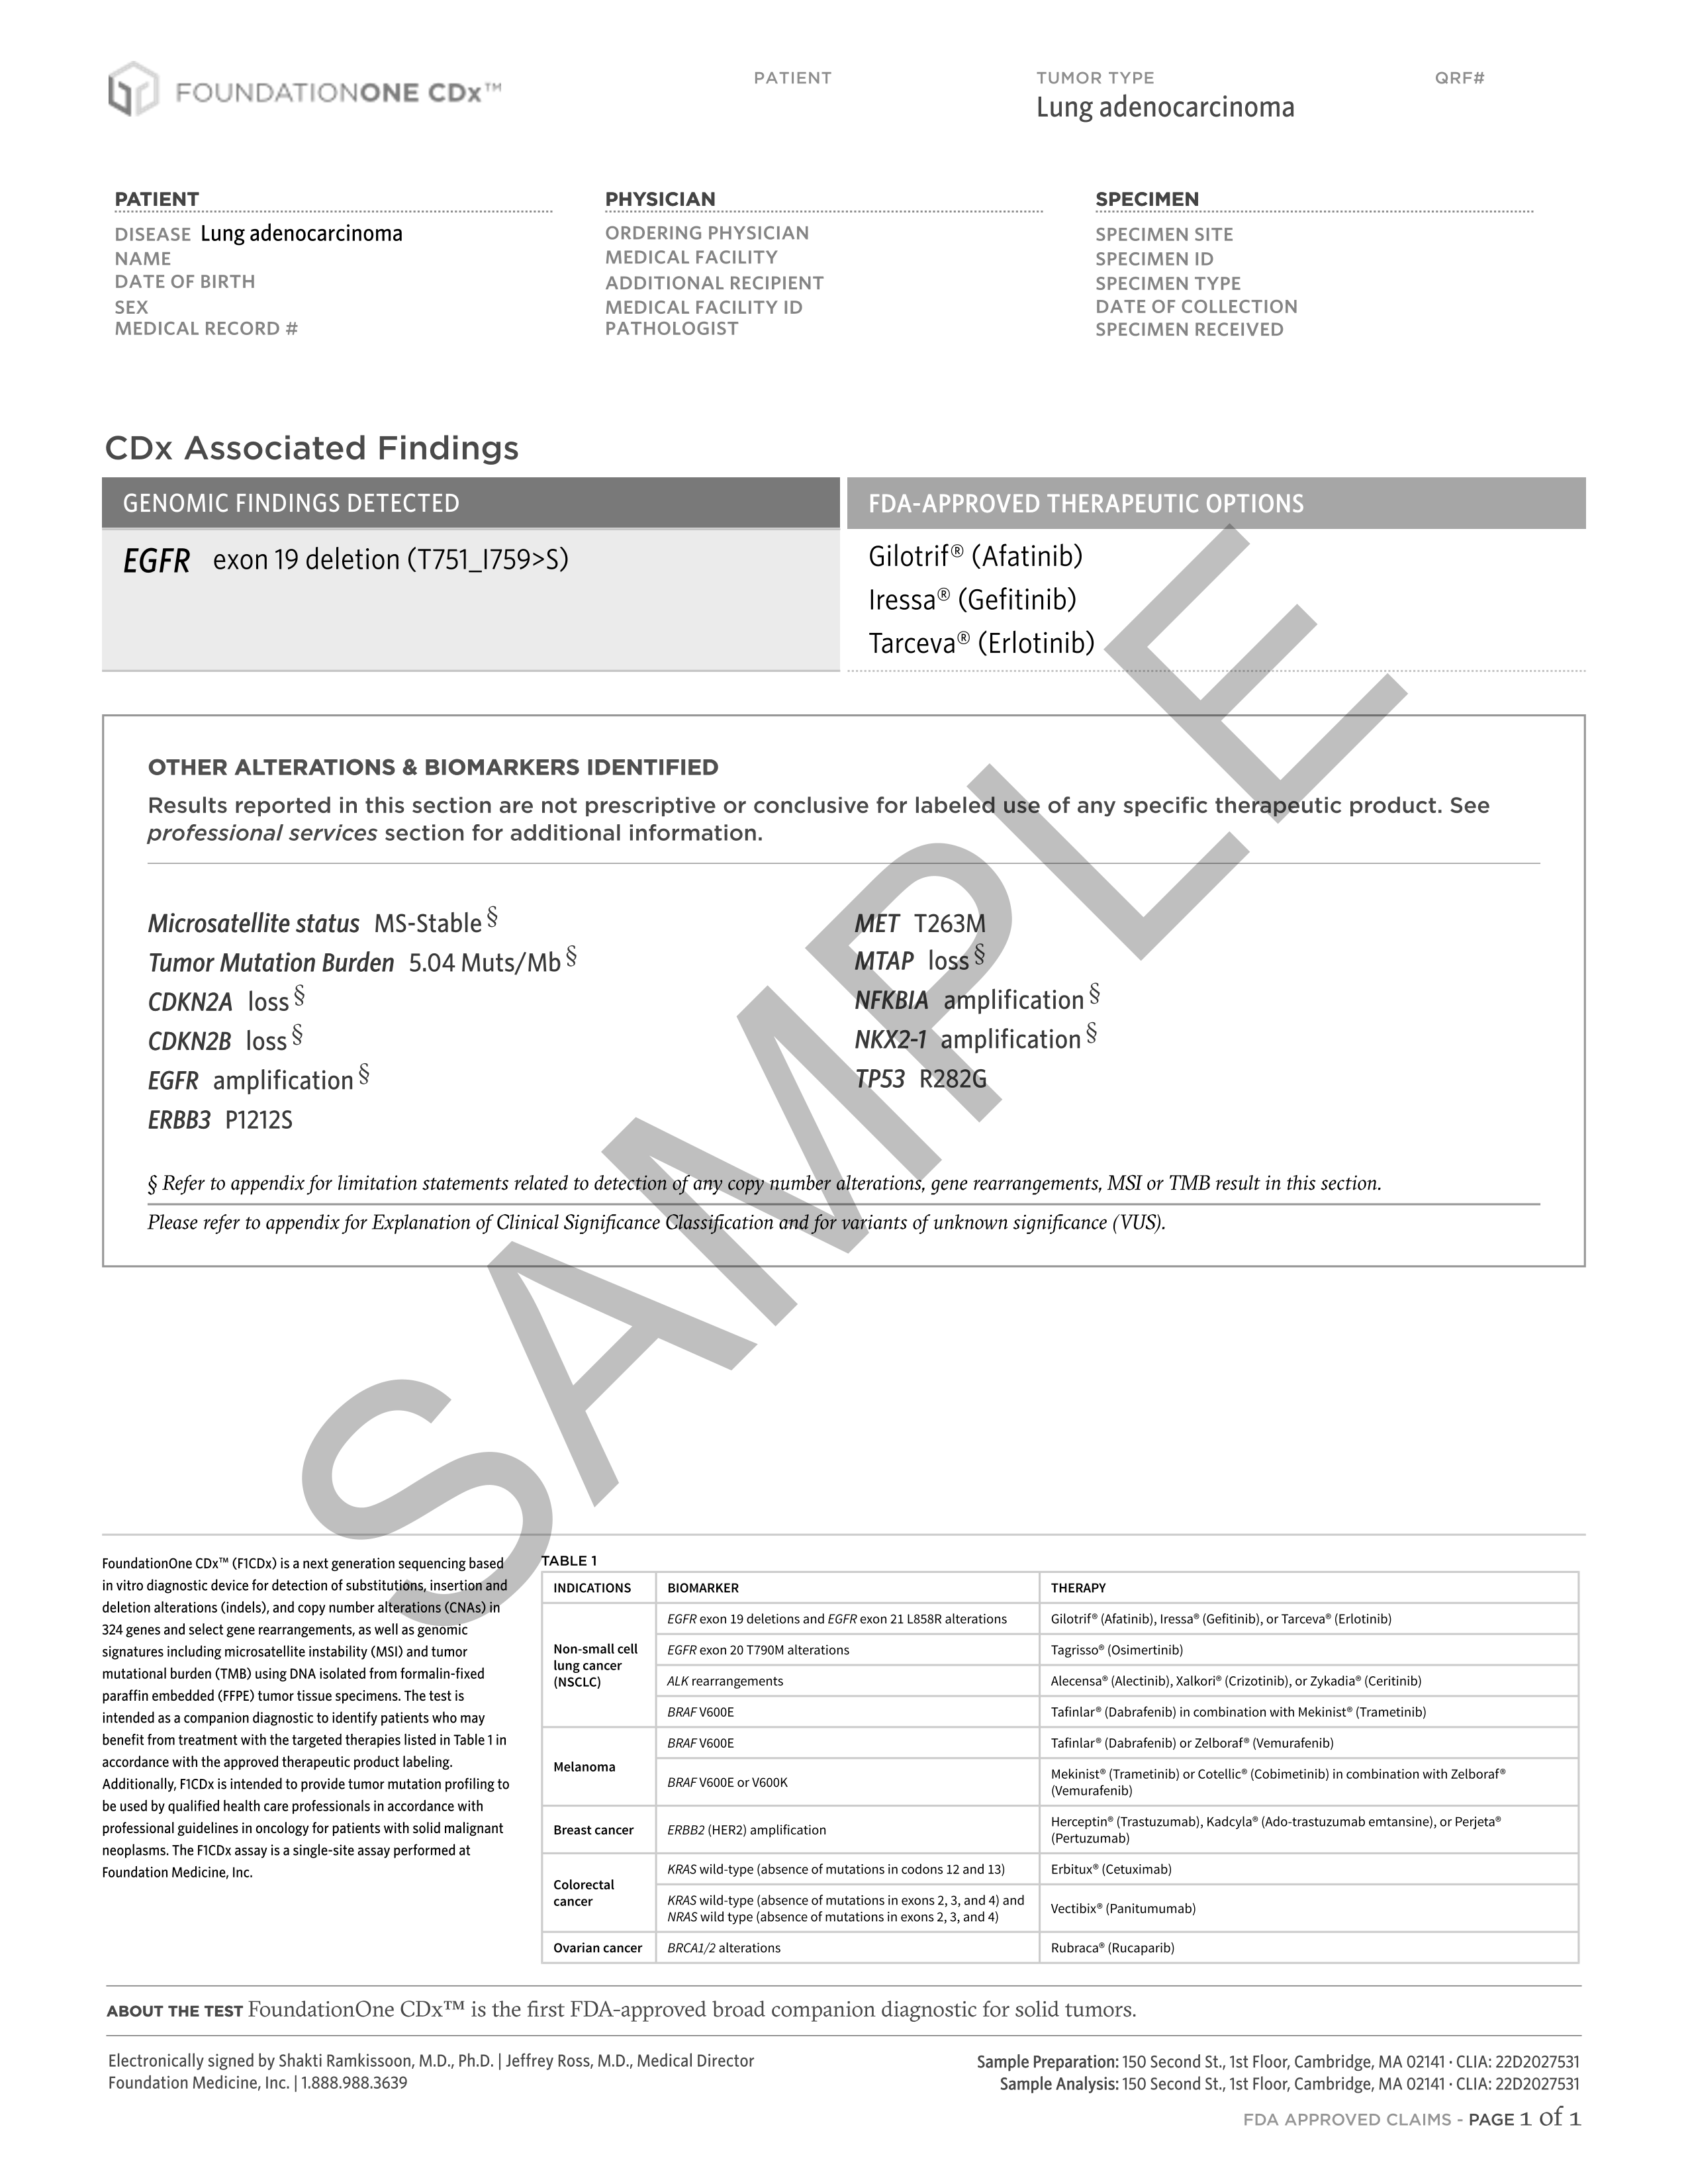

In [15]:
display_image(PdfToImage().transform(pdf_example_df).select("image").collect()[0].image)

## **🔎Run OCR pipelines**

In [16]:
result = pipeline().transform(pdf_example_df).cache()

In [17]:
result

path,modificationTime,length,text,positions,height_dimension,width_dimension,content,pagenum,foundation,exception
file:/content/fou...,2022-06-13 14:24:...,1260852,...,null,792.0,612.0,null,0,"{ ""Appendix"" : ...",null


## **🔎Display results**

In [18]:
print(result.select("foundation").collect()[0].foundation)

{
  "Appendix" : {
    "dna_gene_list" : [ "ABL1", "ACVR1B", "AKT1", "AKT2", "AKT3", "ALK", "ALOX12B", "AMER1", "(FAM123B)", "APC", "AR", "ARAF", "ARFRP1", "ARID1A", "ASXL1", "ATM", "ATR", "ATRX", "AURKA", "AURKB", "AXIN1", "AXL", "BAP1", "BARD1", "BCL2", "BCL2L1", "BCL2L2", "BCL6", "BCOR", "BCORL1", "BRAF", "BRCA1", "BRCA2", "BRD4", "BRIP1", "BTG1", "BTG2", "BTK", "C11orf30", "(EMSY)", "C17orf39", "(GID4)", "CALR", "CARD11", "CASP8", "CBFB", "CBL", "CCND1", "CCND2", "CCND3", "CCNE1", "CD22", "CD274", "(PD-L1)", "CD70", "CD79A", "CD79B", "CDC73", "CDH1", "CDK12", "CDK4", "CDK6", "CDK8", "CDKN1A", "CDKN1B", "CDKN2A", "CDKN2B", "CDKN2C", "CEBPA", "CHEK1", "CHEK2", "CIC", "CREBBP", "CRKL", "CSF1R", "CSF3R", "CTCF", "CTNNA1", "CTNNB1", "CUL3", "CUL4A", "CXCR4", "CYP17A1", "DAXX", "DDR1", "DDR2", "DIS3", "DNMT3A", "DOT1L", "EED", "EGFR", "EP300", "EPHA3", "EPHB1", "EPHB4", "ERBB2", "ERBB3", "ERBB4", "ERCC4", "ERG", "ERRFI1", "ESR1", "EZH2", "FAM46C", "FANCA", "FANCC", "FANCG", "FANCL", "FAS

## **Clear cache**

In [19]:
result.unpersist()

path,modificationTime,length,text,positions,height_dimension,width_dimension,content,pagenum,foundation,exception
file:/content/fou...,2022-06-13 14:24:...,1260852,...,null,792.0,612.0,null,0,"{ ""Appendix"" : ...",null
